# Control System Design

## Linearização da planta

Para a aplicação de um controle no sistema é necessário a linearização das equações da dinâmica do satélite.

No contexto para pequenos ângulos a linearização se dá pela substituição de sin $\theta$ $\approx$ $\theta$ e cos $\theta$ $\approx$ 1,
tem-se portanto:

$\ddot{\phi}=\frac{1}{J_x}(\omega_o^2(J_z-J_y)\phi+\omega_o(J_x+J_z-J_y) \dot{\psi}+T_x)$

$\ddot{\theta}=\frac{T_y}{J_y}$

$\ddot{\psi}=\frac{1}{J_z}(-\omega_o^2(J_y-J_x)\psi-\omega_o(J_z-J_y+J_x) \dot{\phi}+T_z)$


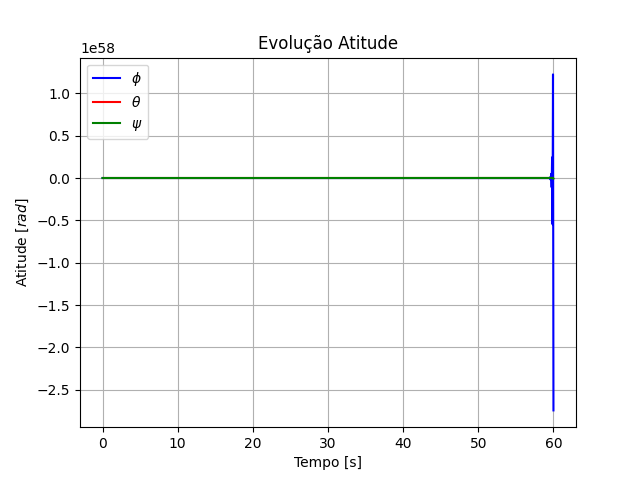

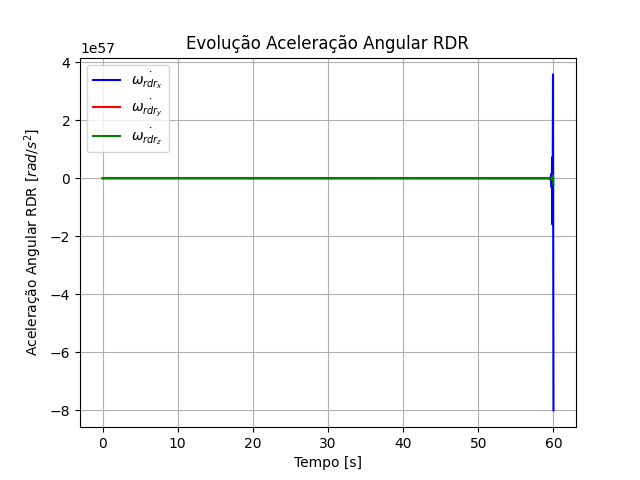

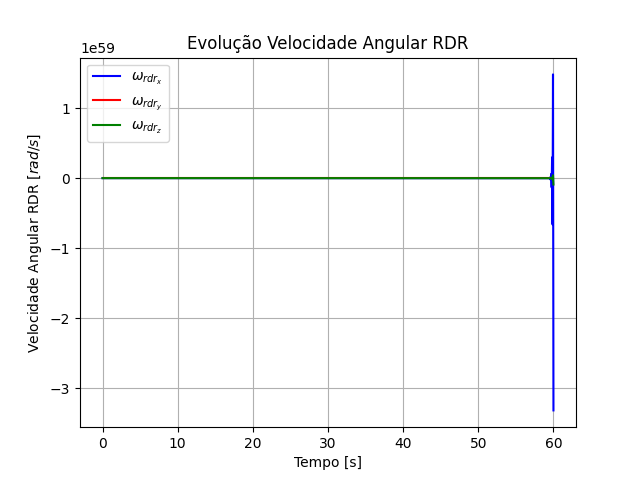

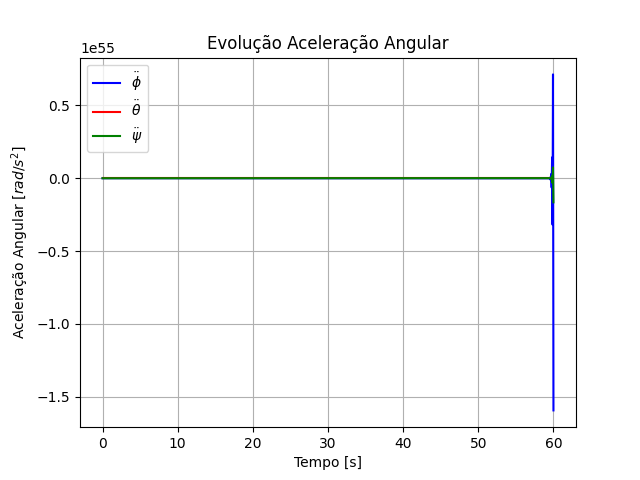

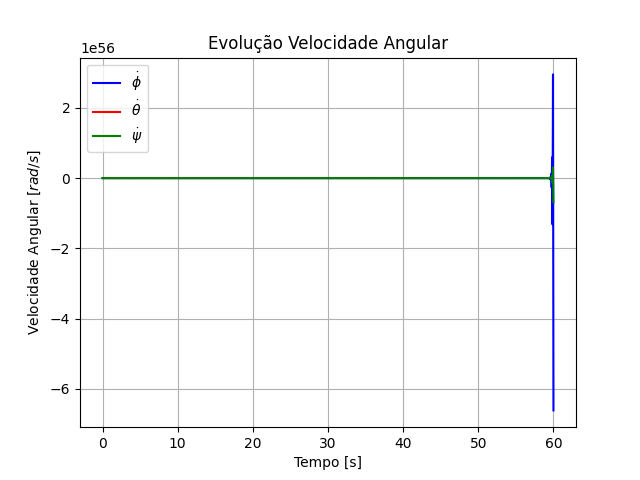

In [ ]:
import matplotlib.pyplot as plt
from numpy import pi
import numpy as np

mu_Terra = 3.98600441e+014

def osv2eko(r_SCGI, v_SCGI):
    global mu_Terra
    # versores sistema de coordenadas inercial centrado na terra J2000
    vec_k = np.array([0, 0, 1])
    vec_i = np.array([1, 0, 0])
    # Elementos orbitais clássicos
    h = np.cross(r_SCGI, v_SCGI) # [m**2/s]
    p = np.dot(h, h)/mu_Terra # [m]
    B = np.cross(v_SCGI,h) - mu_Terra * r_SCGI / np.linalg.norm(r_SCGI) # [m^3/s**2]
    e = B/mu_Terra
    a = p/(1-np.dot(e, e)) # [m]
    vec_N = np.cross(vec_k, h) # [m**2/s]
    i = np.arccos(np.dot(vec_k, h)/np.linalg.norm(h))
    RAAN = np.arccos(np.dot(vec_i, vec_N)/np.linalg.norm(vec_N)) # [rad]
    omega = np.arccos(np.dot(e, vec_N)/(np.linalg.norm(e)*np.linalg.norm(vec_N))) # [rad]
    f = np.real(np.arccos(np.dot(r_SCGI, e)/(np.linalg.norm(e)*np.linalg.norm(r_SCGI)))) # [rad]
    return  [a, e, i, RAAN, omega, f]


r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006]) # m
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003]) # m/s
[a, e, i, RAAN, omega, f] = osv2eko(r_SCGI, v_SCGI)


movimentoMedio = np.sqrt(mu_Terra/a**3) # [rad/s]
w_O_I_O = movimentoMedio

samples = 1000
time_o = 0
time_f = 60
time = np.linspace(time_o,time_f,samples)
phi = np.zeros((samples, 1))
theta = np.zeros((samples, 1))
psi = np.zeros((samples, 1))
dotphi = np.zeros((samples, 1))
dottheta = np.zeros((samples, 1))
dotpsi = np.zeros((samples, 1))
ddotphi = np.zeros((samples, 1))
ddottheta = np.zeros((samples, 1))
ddotpsi = np.zeros((samples, 1))
w_rdr_x = np.zeros((samples, 1))
w_rdr_y = np.zeros((samples, 1))
w_rdr_z = np.zeros((samples, 1))
dotw_rdr_x = np.zeros((samples, 1))
dotw_rdr_y = np.zeros((samples, 1))
dotw_rdr_z = np.zeros((samples, 1))
T_x = np.zeros((samples, 1))
T_y = np.zeros((samples, 1))
T_z = np.zeros((samples, 1))

phi[0] = np.deg2rad(0)
theta[0] = np.deg2rad(0)
psi[0] = np.deg2rad(0)

dotphi[0] = np.deg2rad(0.1)
dottheta[0] = np.deg2rad(0.1)
dotpsi[0] = np.deg2rad(0.1)

# For a CubeSat 6U
cubeSatMass = 6 #  [kg] 
cubeSatLength = 0.1 # [m] -> x
cubeSatWidth = 0.2 # [m] -> y
cubeSatHeight = 0.3 # [m] -> z

Ixx = 1 /12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Iyy = 1 / 12 * cubeSatMass * ((cubeSatLength ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Izz = 1 / 12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatLength ** 2)) # slug * ft ^ 2

# For a RDR
m_rdr = 0.137 # [kg]
r_rdr = 0.0435 # [m]
I_rdr = 0.5*m_rdr*r_rdr**2 # [kg*m²]

K_dotpsi = -10.4
K_dotphi= -27.1


for i in range(len(time)-1):    
    # Controle
    dotw_rdr_x[i+1] = dotw_rdr_x[i]+K_dotphi*dotphi[i]
    w_rdr_x[i+1] = w_rdr_x[i]+dotw_rdr_x[i+1]*time[i+1]  
    T_x[i+1] = I_rdr*dotw_rdr_x[i+1]

    dotw_rdr_z[i+1] = dotw_rdr_z[i]+K_dotpsi*dotpsi[i]
    w_rdr_z[i+1] = w_rdr_z[i]+dotw_rdr_z[i+1]*time[i+1]  
    T_z[i+1] = I_rdr*dotw_rdr_z[i+1]

    # Planta
    ddotphi[i+1] = 1/Ixx*(w_O_I_O**2*(Izz-Iyy)*phi[i]+w_O_I_O*(Ixx+Izz-Iyy)*dotpsi[i]+T_x[i+1])
    ddottheta[i+1] = T_y[i]/Iyy
    ddotpsi[i+1] = 1/Izz*(-w_O_I_O**2*(Iyy-Ixx)*psi[i]-w_O_I_O*(Izz-Iyy+Ixx)*dotphi[i]+T_z[i+1])

    dotphi[i+1] = dotphi[i]+ddotphi[i+1]*time[i+1] 
    dottheta[i+1] = dottheta[i]+ddottheta[i+1]*time[i+1] 
    dotpsi[i+1] = dotpsi[i]+ddotpsi[i+1]*time[i+1]

    phi[i+1] = phi[i]+dotphi[i+1]*time[i+1] 
    theta[i+1] = theta[i]+dottheta[i+1]*time[i+1] 
    psi[i+1] = psi[i]+dotpsi[i+1]*time[i+1] 



plt.figure()
plt.title('Evolução Aceleração Angular RDR')
plt.plot(time,dotw_rdr_x,'b',label=r'$\dot{\omega_{rdr_x}}$')
plt.plot(time,dotw_rdr_y,'r',label=r'$\dot{\omega_{rdr_y}}$')
plt.plot(time,dotw_rdr_z,'g',label=r'$\dot{\omega_{rdr_z}}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular RDR [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular RDR')
plt.plot(time,w_rdr_x,'b',label=r'$\omega_{rdr_x}$')
plt.plot(time,w_rdr_y,'r',label=r'$\omega_{rdr_y}$')
plt.plot(time,w_rdr_z,'g',label=r'$\omega_{rdr_z}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular RDR [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)


# Resultado Torque por Velocidade de Rotação
plt.figure()
plt.title('Evolução Aceleração Angular')
plt.plot(time,ddotphi,'b',label=r'$\ddot{\phi}$')
plt.plot(time,ddottheta,'r',label=r'$\ddot{\theta}$')
plt.plot(time,ddotpsi,'g',label=r'$\ddot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular')
plt.plot(time,dotphi,'b',label=r'$\dot{\phi}$')
plt.plot(time,dottheta,'r',label=r'$\dot{\theta}$')
plt.plot(time,dotpsi,'g',label=r'$\dot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Atitude')
plt.plot(time,phi,'b',label=r'$\phi$')
plt.plot(time,dottheta,'r',label=r'$\theta$')
plt.plot(time,dotpsi,'g',label=r'$\psi$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Atitude [$rad$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)
plt.legend()


plt.show()

### Em espaço de estados teria-se:

- Meu vetor de estados é:

$X = [\phi, \: \theta, \: \psi, \: \dot{\phi}, \: \dot{\theta}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\theta}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\theta}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:,\dot{\omega_{rdr_y}} \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x)) & 0 & 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\frac{1}{J_rdr} & 0 & 0 \\
0 & \frac{1}{J_rdr} & 0 \\
0 & 0 & \frac{1}{J_rdr} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


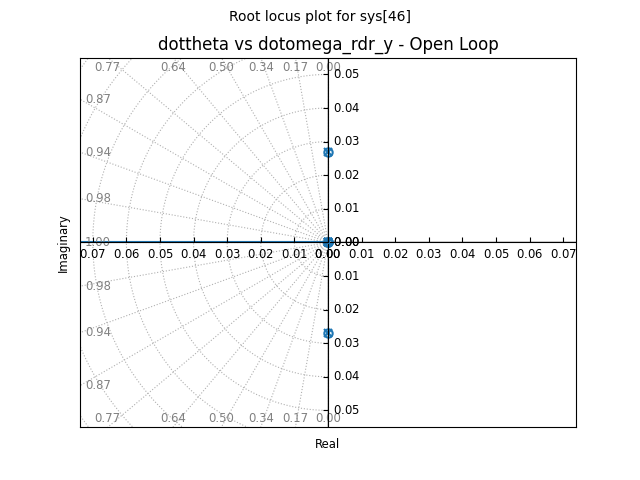

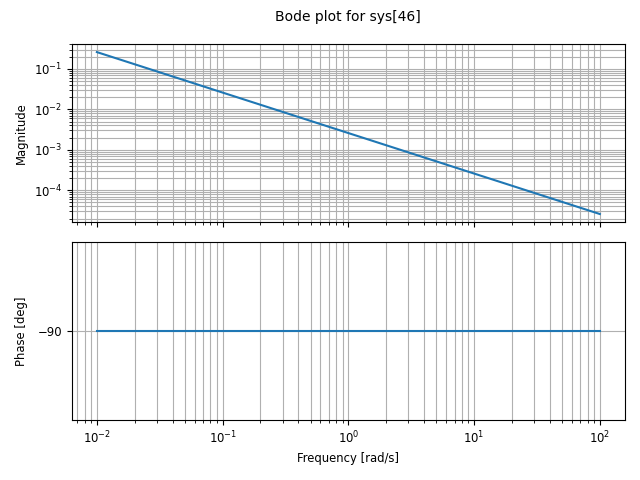

In [28]:
import control
%matplotlib widget

states = ['phi', 'theta', 'psi', 'dotphi', 'dottheta', 'dotpsi']
inputs = ['dotomega_rdr_x', 'dotomega_rdr_y', 'dotomega_rdr_z']

A = np.array([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[1/Ixx*w_O_I_O**2*(Izz-Iyy), 0, 0, 0, 0, 1/Ixx*w_O_I_O*(Ixx+Izz-Iyy)],
[0, 0, 0, 0, 0, 0],
[0, 0, 1/Izz*-w_O_I_O**2*(Iyy-Ixx), 1/Izz*-w_O_I_O/(Izz-Iyy+Ixx),0,0]
])

B = np.array([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[I_rdr/Ixx, 0, 0],
[0, I_rdr/Iyy, 0],
[0, 0, I_rdr/Izz],
])

num_inputs  = B.shape[1]
num_states = A.shape[0]
C = np.eye(num_states)
D = np.zeros([num_states,num_inputs])

selected_states= 'dottheta'
selected_input = 'dotomega_rdr_y'


inputs_index = inputs.index(selected_input)
states_index = states.index(selected_states)

sys = control.StateSpace(A,B[:,inputs_index],C[states_index,:],D[states_index,inputs_index])

plt.figure()
control.root_locus(sys)
plt.title(f"{selected_states} vs {selected_input} - Open Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")


omega = np.logspace(-2, 2, 1000)
control.frequency_response(sys, omega=omega).plot()






## Projeto de Controlador

Text(0, 0.5, 'Imaginary')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


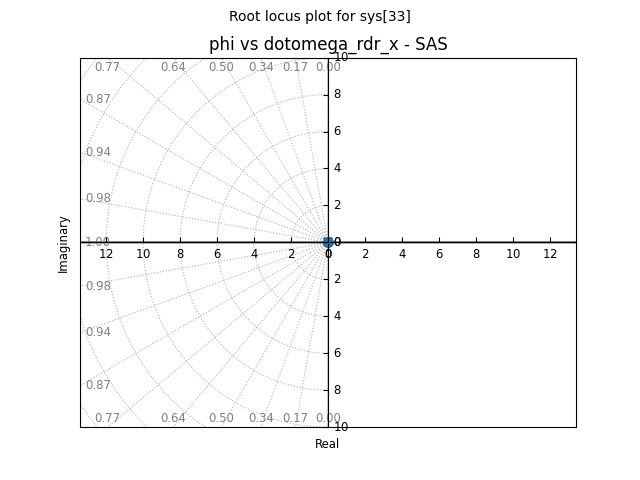

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


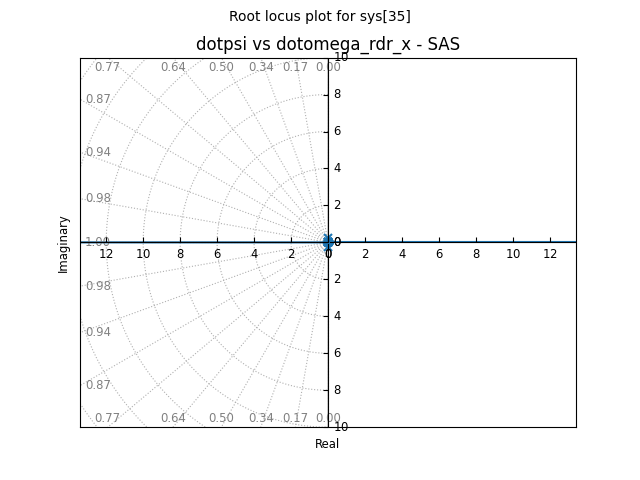

In [14]:
#%% Control design - K_phi

selected_states= 'phi'
selected_input = 'dotomega_rdr_x'

inputs_index = inputs.index(selected_input)
states_index = states.index(selected_states)

K_phi= 0.3887

K = np.zeros([1,num_states])
K[0][inputs_index] = K_phi


B_rdr_x = -B[:,inputs_index:inputs_index+1]

# Define the closed-loop system state-space matrices

A_SAS = A - K*B_rdr_x

C_phi = C[states_index,:]


# Create state-space systems for open-loop plant and closed-loop system with PID controller
sys_SAS = control.StateSpace(A_SAS, B_rdr_x, C_phi, 0)

plt.figure()
control.root_locus(sys_SAS)
plt.title(f"{selected_states} vs {selected_input} - SAS")
plt.ylim([-10, 10])
plt.xlim([-10, 10]) 
plt.xlabel("Real")
plt.ylabel("Imaginary")

#%% Control design - K_dotpsi

selected_states= 'dotpsi'
selected_input = 'dotomega_rdr_x'

inputs_index = inputs.index(selected_input)
states_index = states.index(selected_states)

K_dotpsi= 0.005291

K = np.zeros([1,num_states])
K[0][inputs_index] = K_dotphi


B_rdr_x = B[:,inputs_index:inputs_index+1]

# Define the closed-loop system state-space matrices

A_SAS = A - K*B_rdr_x

C_dotpsi = C[states_index,:]


# Create state-space systems for open-loop plant and closed-loop system with PID controller
sys_SAS = control.StateSpace(A_SAS, B_rdr_x, C_dotpsi, 0)

plt.figure()
control.root_locus(sys_SAS)
plt.title(f"{selected_states} vs {selected_input} - SAS")
plt.ylim([-10, 10])
plt.xlim([-10, 10]) 
plt.xlabel("Real")
plt.ylabel("Imaginary")




Text(0, 0.5, 'Imaginary')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


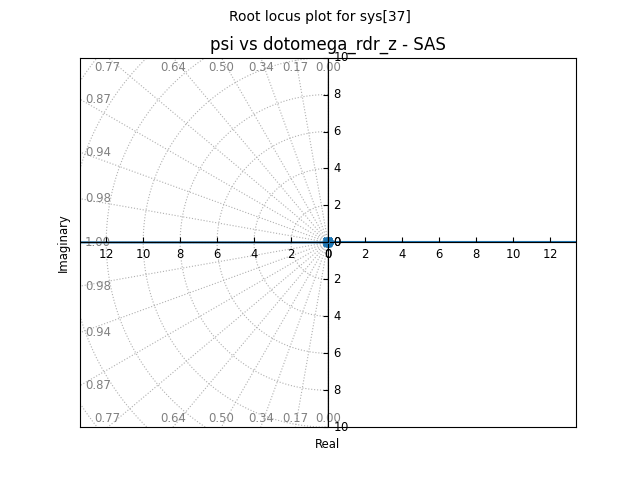

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


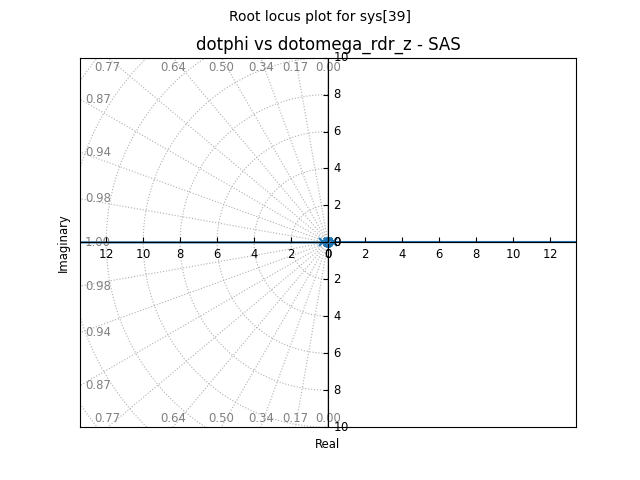

In [15]:
#%% Control design - K_psi

selected_states= 'psi'
selected_input = 'dotomega_rdr_z'

inputs_index = inputs.index(selected_input)
states_index = states.index(selected_states)

K_psi= 3.64e-7

K = np.zeros([1,num_states])
K[0][inputs_index] = K_psi


B_rdr_x = -B[:,inputs_index:inputs_index+1]

# Define the closed-loop system state-space matrices

A_SAS = A - K*B_rdr_x

C_psi = C[states_index,:]


# Create state-space systems for open-loop plant and closed-loop system with PID controller
sys_SAS = control.StateSpace(A_SAS, B_rdr_x, C_psi, 0)

plt.figure()
control.root_locus(sys_SAS)
plt.ylim([-10, 10])
plt.xlim([-10, 10]) 
plt.title(f"{selected_states} vs {selected_input} - SAS")
plt.xlabel("Real")
plt.ylabel("Imaginary")

#%% Control design - K_dotphi

selected_states= 'dotphi'
selected_input = 'dotomega_rdr_z'

inputs_index = inputs.index(selected_input)
states_index = states.index(selected_states)

K_dotphi= 13.18

K = np.zeros([1,num_states])
K[0][inputs_index] = K_dotphi


B_rdr_z = -B[:,inputs_index:inputs_index+1]

# Define the closed-loop system state-space matrices

A_SAS = A - K*B_rdr_x

C_dotphi = C[states_index,:]


# Create state-space systems for open-loop plant and closed-loop system with PID controller
sys_SAS = control.StateSpace(A_SAS, B_rdr_z, C_dotphi, 0)

plt.figure()
control.root_locus(sys_SAS)
plt.ylim([-10, 10])
plt.xlim([-10, 10]) 
plt.title(f"{selected_states} vs {selected_input} - SAS")
plt.xlabel("Real")
plt.ylabel("Imaginary")


